<a href="https://colab.research.google.com/github/marquito3012/TFG/blob/main/FaceDetectionCropping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.9/906.9 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.4 MB/s eta 0:00:00
/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Person-Faces-5 in yolov11:: 100%|██████████| 6034/6034 [00:01<00:00, 5210.10it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
/content


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.



0: 640x640 1 face, 541.2ms
Speed: 11.5ms preprocess, 541.2ms inference, 34.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict

0: 640x640 1 face, 336.9ms
Speed: 4.9ms preprocess, 336.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict

0: 640x640 7 faces, 352.3ms
Speed: 3.2ms preprocess, 352.3ms inference, 7.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict

0: 640x640 3 faces, 363.4ms
Speed: 5.9ms preprocess, 363.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict

0: 640x640 1 face, 298.8ms
Speed: 6.4ms preprocess, 298.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict

0: 640x640 1 face, 209.7ms
Speed: 4.0ms preprocess, 209.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict

0: 640x640 1 face

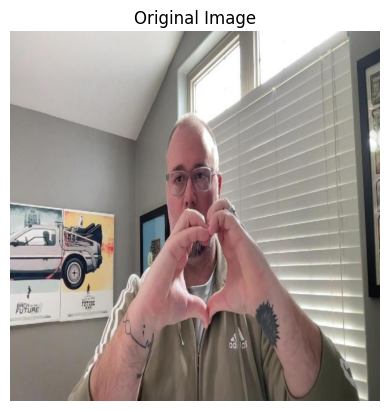

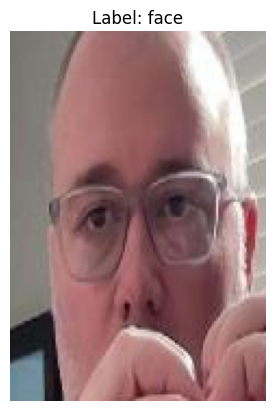

Image: /content/datasets/Person-Faces-5/test/images/gravitate-faces_mp4-148_jpg.rf.727704267c2d838126d0b1c86493f28e.jpg


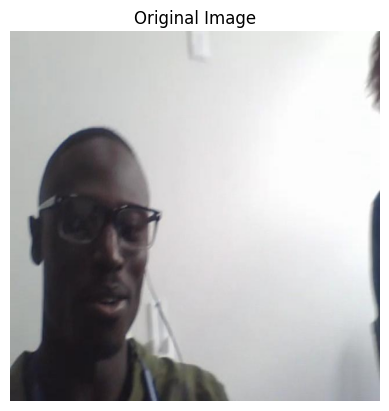

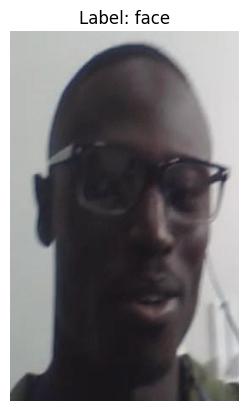

Image: /content/datasets/Person-Faces-5/test/images/TASS38012699_jpg.rf.9dc91f9cbc7641b41f581a2591e26191.jpg


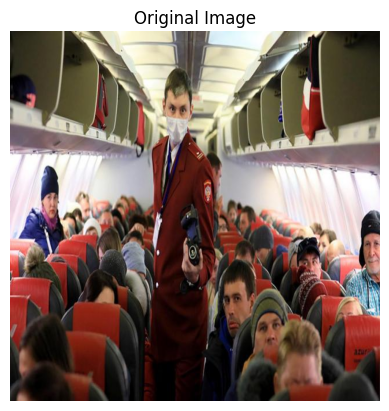

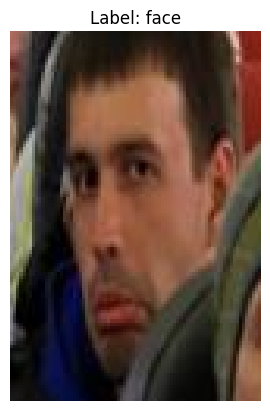

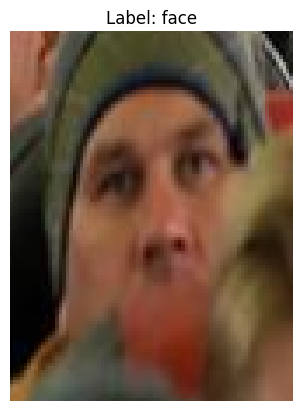

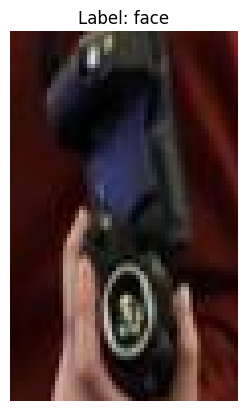

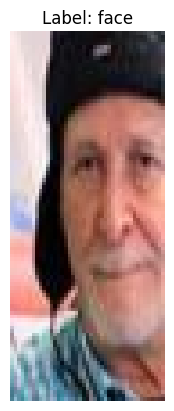

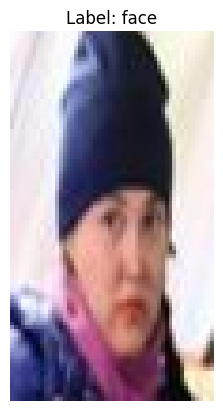

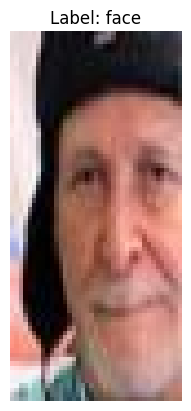

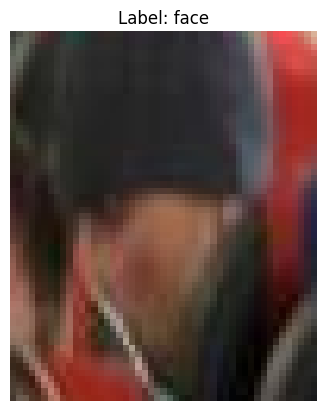

Image: /content/datasets/Person-Faces-5/test/images/mask-wearing-1632931973069_png_jpg.rf.e1145268e7b3d54fc8b68fa26b4f1f4c.jpg


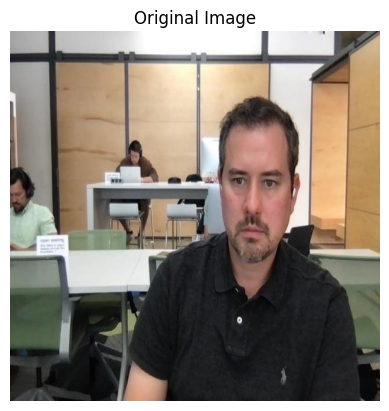

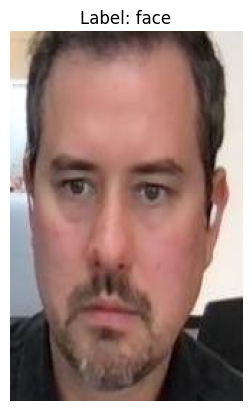

In [ ]:
import os
HOME = os.getcwd()
!pip install ultralytics
!pip install -q supervision roboflow
!mkdir {HOME}/datasets
%cd {HOME}/datasets
!pip install -q roboflow
from google.colab import userdata
from roboflow import Roboflow

rf = Roboflow(api_key="9KG8ovuhVxeymK6aMBor")
project = rf.workspace("face-detection-and-recognition-dataset").project("person-faces")
version = project.version(5)
dataset = version.download("yolov11")

import yaml

with open(f"{dataset.location}/data.yaml", "r") as f:
    data_config = yaml.safe_load(f)
    class_names = data_config["names"]


from ultralytics import YOLO
import supervision as sv

%cd {HOME}
model = YOLO("best.pt")

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

import random
import pickle
import cv2

dic = {}

for image_path, image_data in dataset.images.items():
  # Carga la imagen actual
  image = image_data

  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

  # Genera predicciones con el modelo
  results = model(source=image, conf=0.20, save = True, save_crop = True)[0]
  detections = sv.Detections.from_ultralytics(results)

  # Extrae los crops (recortes) y labels (etiquetas)
  image_crops = []
  image_labels = []
  height, width, _ = image.shape # Dimensiones de la imagen

  padding = 10 # Tamaño de padding para los crops
  for detection, class_id in zip(detections.xyxy, detections.class_id):
    x_min, y_min, x_max, y_max = map(int, detection[:4])

    # Ajusta las coordenadas con padding
    x_min = max(0, x_min - padding)
    y_min = max(0, y_min - padding)
    x_max = min(width, x_max + padding)
    y_max = min(height, y_max + padding)

    crop = image[y_min:y_max, x_min:x_max]
    image_crops.append(crop)

    # Obten el nombre de la clase usando class_id
    label = class_names[class_id]
    image_labels.append(label)

  # Guarda los crops y labels de la imagen actual en el diccionario
  dic[image_path] = {"image": image, "crops": image_crops, "labels": image_labels}

# Guarda el diccionario en un archivo pickle
with open("crops_and_labels.pkl", "wb") as f:
    pickle.dump(dic, f)

print("Crops and labels saved to 'crops_and_labels.pkl'.")

with open("crops_and_labels.pkl", "rb") as f:
    loaded_dic = pickle.load(f)

print("Crops and labels loaded from 'crops_and_labels.pkl'.")

import matplotlib.pyplot as plt

# Mostrar los primeros 10 crops (si existen)
count = 0
for image_path, data in loaded_dic.items():
    print(f"Image: {image_path}")
    plt.imshow(data["image"])
    plt.title("Original Image")
    plt.axis("off")  # Ocultar ejes
    plt.show()
    for crop, label in zip(data["crops"], data["labels"]):
        # Mostrar el crop
        plt.imshow(crop)
        plt.title(f"Label: {label}")
        plt.axis("off")  # Ocultar ejes
        plt.show()

        count += 1
        if count >= 10:  # Detener después de los primeros 10 crops
            break
    if count >= 10:
        break